In [1]:
import pandas as pd
import yaml
from utilities import exposure_new, read_ac_data, gdp_from_cdd_exposure, read_projections, add_historical_gdp_growth, calculate_average_gdp_growth
from plotting import plot_exposure_map, plot_exposure_contour, plot_gdp_increase_map, plot_gdp_increase_scatter

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
# Load data
ref_year = config["ref_year"]


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  projection_df = projection_df[(projection_df_all['ssp'] == ssp) & (projection_df['rcp'] == rcp) & (projection_df['stat'] == 'mean')]
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  projection_df = projection_df[(projection_df_all['ssp'] == ssp) & (projection_df['rcp'] == rcp) & (projection_df['stat'] == 'mean')]
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  projection_df = projection_df[(projection_df_all['ssp'] == ssp) & (projection_df['rcp'] == rcp) & (projection_df['stat'] == 'mean')]
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  projectio

Number of countries with data: 107


/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Number of countries with data: 109


/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Number of countries with data: 108


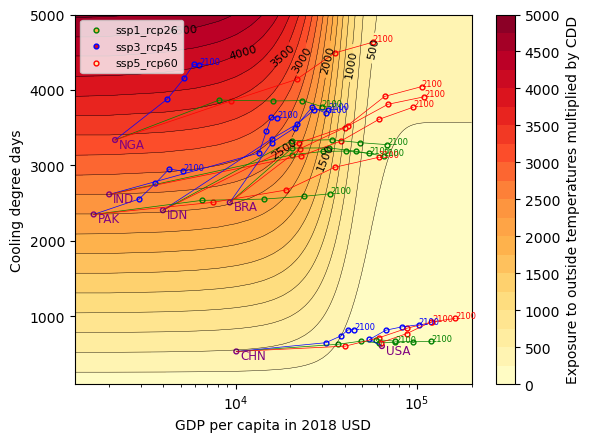

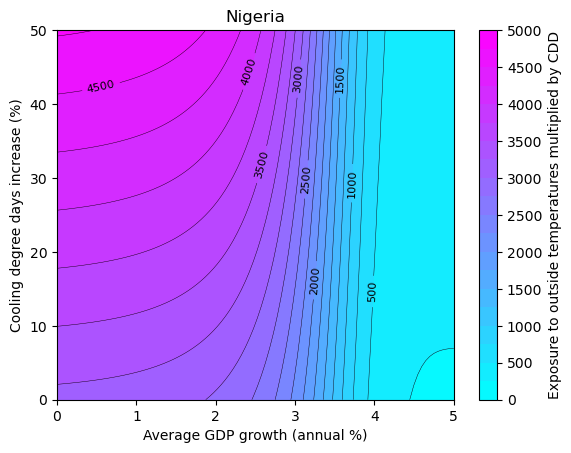

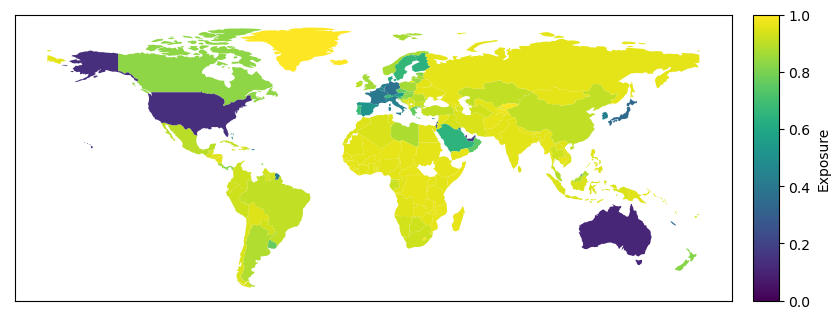

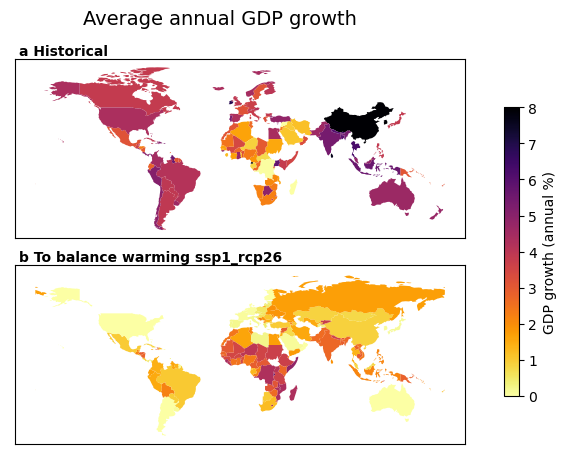

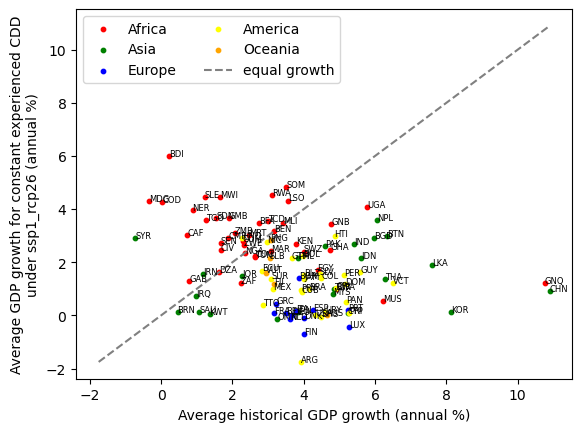

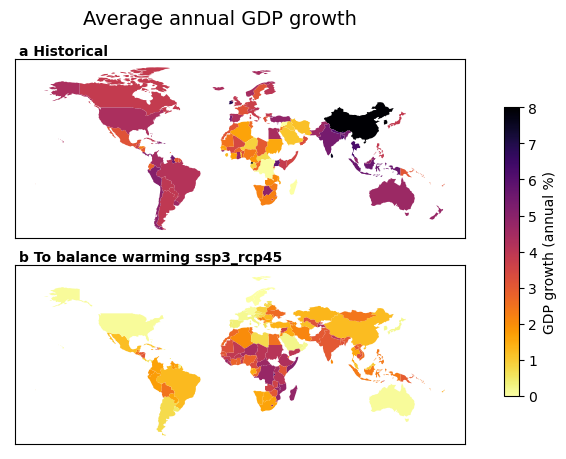

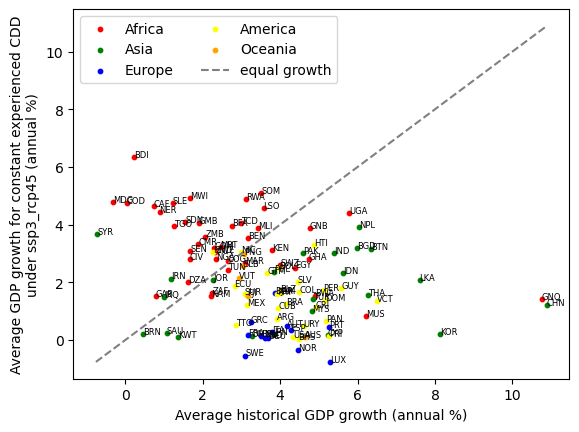

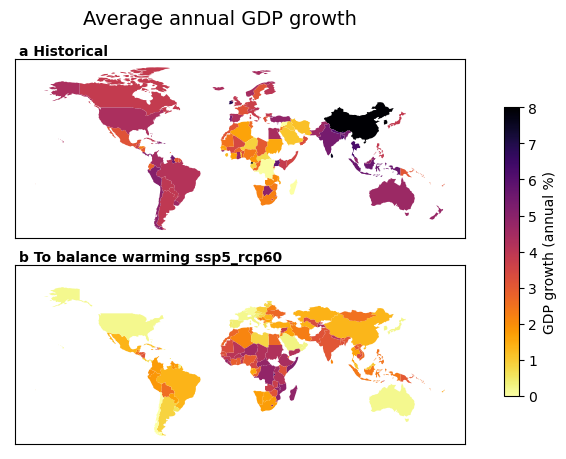

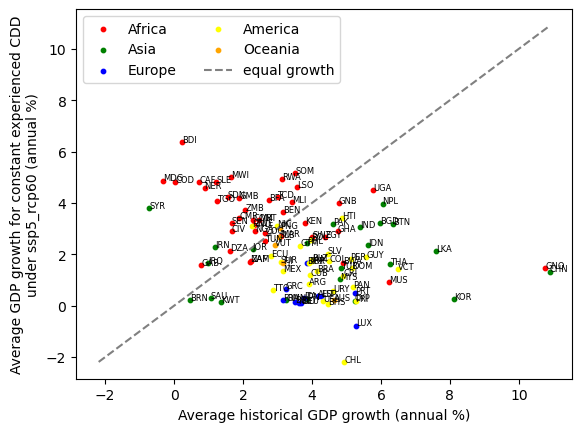

In [3]:
# Read in historical AC, GDP, DD data
ac_data_historical = read_ac_data('data_experiencedT/AC_data.csv')

# Add predictions for DD_mean and GDP for the countries in ac_data
dd_projections = read_projections(config, 'cdd')
dd_projections = dd_projections[dd_projections['ISO3'].isin(ac_data_historical['ISO3'])]

gdp_projections = read_projections(config, 'gdp')
gdp_projections = gdp_projections[gdp_projections['ISO3'].isin(ac_data_historical['ISO3'])]

# # Merge the two dataframes
merged_projections = pd.merge(dd_projections, gdp_projections, on='ISO3')

# Add to ac_data without append
ac_data = pd.merge(ac_data_historical, merged_projections, on='ISO3')
ac_data = ac_data.reset_index(drop=True)

# Contour data for exposure if value for AC is available if not _2100 is added to ISO3 and also the corresponding countries with _2100
ac_data_contour = ac_data.copy()
ac_data_countries = ac_data_contour['ISO3'].unique() + '_2100'
ac_data_contour = pd.concat([ac_data_contour, ac_data[ac_data['ISO3'].isin(ac_data_countries)]])

# Plot exposure contour
plot_exposure_contour(config, exposure_new, ac_data_contour, name_tag='exposure_contour')

# Plot contour for one country with x and y percent increase in CDD and GDP
ac_data_contour_NIG = ac_data_contour.copy()
plot_exposure_contour(config, exposure_new, ac_data_contour, add_data=False, name_tag='exposure_contour_NGA')


# Plot exposure map
ac_data_map_geo = plot_exposure_map(ac_data_historical)


# Compute change in experienced CDD compared to present (2018)    
# Copy ac_data to ac_data_new and only keep ISO3, DD_mean and GDP columns
ac_data_new = ac_data.copy()
# Add column for exposure times CDD
ac_data_new['exposure_times_cdd'] = exposure_new(ac_data_new['GDP'], ac_data_new['DD_mean'])*ac_data_new['DD_mean']

# ac_data_new['diff_exposure_times_cdd'] = ac_data_new_2100['exposure_times_cdd'].values - ac_data_new['exposure_times_cdd'].values
# ac_data_new['diff_cdd'] = ac_data_new_2100['DD_mean'].values - ac_data_new['DD_mean'].values

ac_data_new = add_historical_gdp_growth(ac_data_new)
ac_data_map_geo.set_index('ISO3', inplace=True)
ac_data_new.set_index('ISO3', inplace=True)

for scenario in config['future_scenarios']:
    # Calculate GDP needed to keep exposure times CDD constant
    gdp_const = gdp_from_cdd_exposure(ac_data_new['exposure_times_cdd'], ac_data_new['CDD_{0}_{1}'.format(scenario, config['future_years'][-1])])
    ac_data_new['gdp_const_{}'.format(scenario)] = calculate_average_gdp_growth(gdp_const, ac_data_new['GDP'], config['future_years'][-1] - 2018)
    
    plot_gdp_increase_map(config, ac_data_new, ac_data_map_geo, scenario)
    plot_gdp_increase_scatter(ac_data_new, scenario)
